In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip 'drive/My Drive/Audio_Song_Actors_01-24.zip' -d 'audio_song/'
!unzip 'drive/My Drive/Audio_Speech_Actors_01-24.zip' -d 'audio_speech/'
# !unzip 'drive/My Drive/audio_data.zip' 


    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
    Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [0]:
mkdir -p audio_data/train audio_data/test

In [0]:
!cp audio_speech/Actor_0*/* audio_data/train
!cp audio_speech/Actor_1*/* audio_data/train



In [0]:
!cp audio_speech/Actor_2*/* audio_data/test


In [0]:
rm -rf image_data/train/

In [0]:
TRAIN_AUDIO_PATH = (f'{"audio_data/train/"}')
VALID_AUDIO_PATH = (f'{"audio_data/test/"}')
TRAIN_IMAGE_PATH = (f'{"image_data/train/"}')
VALID_IMAGE_PATH = (f'{"image_data/test/"}')
TRAIN_AUDIO_PATH, VALID_AUDIO_PATH

('audio_data/train/', 'audio_data/test/')

In [0]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    filename = f'{src_path}{fname}'
#     print(filename)
    x, sample_rate = librosa.load(filename)
#     f = list(fname)
#     rank = int(f[7])
#     if rank>1:
#       rank-=1
#     f[7] = str(rank)
#     fname = "".join(f)
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
#     dst_fname = dst_path / (fname[:-4] + '.png')
    dst_fname = f'{dst_path}{fname[:-4]}{".png"}'
    plt.imsave(dst_fname, mel_spec_db)

In [0]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [0]:
for file in os.listdir(TRAIN_AUDIO_PATH):
  log_mel_spec_tfm(file,TRAIN_AUDIO_PATH,TRAIN_IMAGE_PATH)

In [0]:
for file in os.listdir(VALID_AUDIO_PATH):
  log_mel_spec_tfm(file,VALID_AUDIO_PATH,VALID_IMAGE_PATH)

In [0]:
# !zip -r image_data.zip image_data

In [0]:
import fastai
from fastai.vision import *
from fastai.basics import *

In [0]:
Emotions = ['neutral','happy','sad','angry','fearful','disgust','surprised']
def func(file_path): 
  rank = int(str(file_path)[-17])
  rank-=1
  if rank>1:
    rank-=1
  return rank

print(func(Path('02-01-04-02-02-01-12.png')))

2


In [0]:
# rm -rf image_data/test/03-01-02*

In [0]:
# def func(file_path): return str(file_path)[-17]
src = (ImageList.from_folder('image_data')
            .split_by_folder('train','test')
            .label_from_func(func))
tfms = None # or tfms=None if none are needed
size=(40,265)# or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=10, num_workers=16).normalize()

In [0]:
data.c, data.classes


(7, [0, 1, 2, 3, 4, 5, 6])

In [0]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([10, 3, 40, 265]), torch.Size([10]))

In [0]:
xs.min(), xs.max(), xs.mean(), xs.std()


(tensor(0.0039), tensor(0.9922), tensor(0.3204), tensor(0.1953))

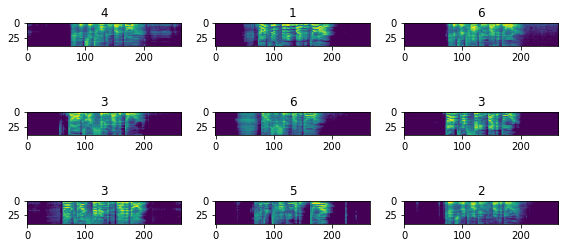

In [0]:
data.show_batch(3, figsize=(8,4), hide_axis=False)


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.142187,1.793093,0.357692,00:09
1,1.705742,1.773600,0.311538,00:09
2,1.350187,1.737336,0.326923,00:09


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


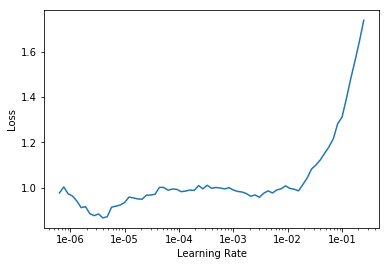

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3,max_lr=slice(8e-4,2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.103808,1.835753,0.369231,00:09
1,1.155479,1.762476,0.411538,00:09
2,0.837300,1.726216,0.407692,00:09


0-Neutral 1-Happy 2-sad 3-angry 4-fearful 5-disgust 6-surprised 

In [0]:
learn.fit_one_cycle(10,max_lr=slice(3e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.103453,1.074876,0.663462,00:23
1,0.262514,1.354884,0.621154,00:23
2,0.365549,1.617003,0.594231,00:23
3,0.301344,1.205544,0.621154,00:23
4,0.268760,1.472892,0.592308,00:23
5,0.167061,0.993117,0.661538,00:23
6,0.099233,1.221733,0.642308,00:23
7,0.053559,1.276873,0.636538,00:23
8,0.027164,1.176638,0.648077,00:23
9,0.020239,1.166791,0.659615,00:23


In [0]:
learn.save('stage1_ravdess')

In [0]:
!unzip 'drive/My Drive/torontov2.zip' 

In [0]:
# !zip -r model.zip image_data/models

In [0]:
TRAIN_AUDIO_PATH = (f'{"toronto/"}')
VALID_AUDIO_PATH = (f'{"audio_data/test/"}')
TRAIN_IMAGE_PATH = (f'{"image_data/train/"}')
VALID_IMAGE_PATH = (f'{"image_data/test/"}')
TRAIN_AUDIO_PATH, VALID_AUDIO_PATH

In [0]:
# !zip -r image_data.zip image_data

In [0]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    filename = f'{src_path}{fname}'
#     print(filename)
    x, sample_rate = librosa.load(filename)
#     f = list(fname)
#     rank = int(f[7])
#     if rank>1:
#       rank-=1
#     f[7] = str(rank)
#     fname = "".join(f)
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
#     dst_fname = dst_path / (fname[:-4] + '.png')
    dst_fname = f'{dst_path}{fname[:-4]}{".png"}'
    plt.imsave(dst_fname, mel_spec_db)

In [0]:
for folder in os.listdir('toronto'):
  for file in os.listdir(f'{"toronto/"}{folder}'):
    log_mel_spec_tfm(file, f'{"toronto/"}{folder}{"/"}', f'{"toronto_images/"}{folder}{"/"}')

TESS DATASET

In [0]:

# def func(file_path): return str(file_path)[-17]
src = (ImageList.from_folder('toronto_images')
                .split_by_rand_pct(valid_pct=0.2, seed=46)
                .label_from_folder())
tfms = None # or tfms=None if none are needed
size=(40,265)# or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=10, num_workers=16).normalize()

In [0]:
data.c, data.classes

(7, ['0', '1', '2', '3', '4', '5', '6'])

In [0]:
!cp image_data/models/stage1_ravdess.pth toronto_images/models


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load("stage1_ravdess")
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.702320,0.263767,0.919786,00:18
1,0.355759,0.137691,0.953654,00:18
2,0.220572,0.109496,0.967914,00:18


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


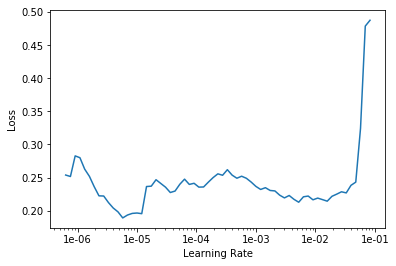

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3,max_lr=slice(3e-4,7e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.198327,0.077266,0.975045,00:18
1,0.162088,0.052106,0.985740,00:18
2,0.118277,0.041186,0.989305,00:18


In [0]:
learn.save("stage1_ravdess_tess")

In [0]:
!cp toronto_images/models/stage1_ravdess_tess.pth image_data/models

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

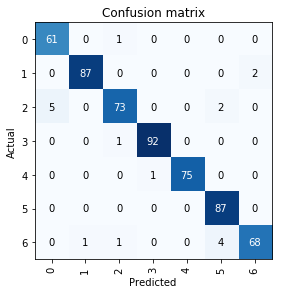

In [0]:
interp.plot_confusion_matrix()

RAVDESS DATA

In [0]:
# def func(file_path): return str(file_path)[-17]
src = (ImageList.from_folder('image_data')
            .split_by_folder('train','test')
            .label_from_func(func))
tfms = None # or tfms=None if none are needed
size=(40,265)# or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=10, num_workers=16).normalize()

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load("stage1_ravdess_tess")

In [0]:
learn.export('export.pkl')

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
accuracy(preds,y)

tensor(0.1808)

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,1.685249,1.869229,0.419231,00:09
0,1.685249,1.869229,0.419231,00:09
1,1.100593,1.784821,0.453846,00:09
1,1.100593,1.784821,0.453846,00:09
2,0.851436,1.774948,0.465385,00:09
2,0.851436,1.774948,0.465385,00:09


In [0]:
learn.save("stage2_ravdess_tess_ravdess")

In [0]:
!cp image_data/models/stage2_ravdess_tess_ravdess.pth toronto_images/models

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load("stage2_ravdess_tess_ravdess")

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
accuracy(preds,y)

tensor(0.4207)

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.331311,0.097647,0.969697,00:18
0,0.331311,0.097647,0.969697,00:18
1,0.171697,0.057253,0.982175,00:18
1,0.171697,0.057253,0.982175,00:18
2,0.158981,0.050759,0.980392,00:18
2,0.158981,0.050759,0.980392,00:18


In [0]:
learn.save("stage2_ravdess_tess_ravdess_tess")
!cp toronto_images/models/stage2_ravdess_tess_ravdess_tess.pth image_data/models

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load("stage2_ravdess_tess_ravdess_tess")

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
accuracy(preds,y)

tensor(0.1923)

In [0]:
!cp 'drive/My Drive/speaker1.wav' sit_test_samples/
!cp 'drive/My Drive/speaker2.wav' sit_test_samples/

In [0]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    filename = f'{src_path}{fname}'
#     print(filename)
    x, sample_rate = librosa.load(filename)
#     f = list(fname)
#     rank = int(f[7])
#     if rank>1:
#       rank-=1
#     f[7] = str(rank)
#     fname = "".join(f)
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
#     dst_fname = dst_path / (fname[:-4] + '.png')
    dst_fname = f'{dst_path}{fname[:-4]}{".png"}'
    plt.imsave(dst_fname, mel_spec_db)

In [0]:
log_mel_spec_tfm('speaker1.wav', 'sit_test_samples/','sit_test_samples/')
log_mel_spec_tfm('speaker2.wav', 'sit_test_samples/','sit_test_samples/')

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
accuracy(preds,y)

In [0]:
!mv sit_test_samples/speaker1.wav .
!mv sit_test_samples/speaker2.wav .

In [0]:

test = (ImageList.from_folder('sit_test_samples'))
learn = load_learner("toronto_images",test=test)

# tfms = None # or tfms=None if none are needed
# size=(40,265)# or (400,224)
# data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=1, num_workers=16).normalize()

In [0]:

preds, _ = learn.get_preds(ds_type=DatasetType.Test)
# thresh = 0.2
# labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
# fnames = [f.name[:-4] for f in learn.data.test_ds.items]
# df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
# dataframes.append(df)

In [0]:
preds

tensor([[0.0614, 0.0866, 0.0486, 0.0318, 0.4191, 0.3129, 0.0396],
        [0.0046, 0.0263, 0.0407, 0.0352, 0.4229, 0.4557, 0.0145]])